## DSCPM Volume Infused vs. Time and Flow-rate vs. Time data processing
#### This code was used to process data and generate plots for Figure 4 of *A Continuous, Low Flow, and Multiplexing Pumping System for Microfluidics Applications*, by K. A. Walp, Y. H. Patel, W. Alsadoun, H. L. Gordon, H. Rastaghi, S. M. D. Oliveira*


This code takes in pre-cropped, horizontal videos of fluid being infused through micro-bore tubing (dyed fluid against a white background for good contrast)

The code then runs an algorithm which detects vertical edges on each frame of the video. Using the frame rate per second, and the measured distance (and calculated volume, with tubing dimensions) per pixel, volume infused with respect to time is measured and plotted.

Flow rate is the derivative of volume infused with respect to time, so a running average (to clean up noise) of volume infused with respect to time is calculated to obrain flow rate with respect of time. 

\* Generative AI was used in the development of this code. The authors thoroughly confirmed the validity and accuracy of the image processing with  respect to the raw data (videos), and take responsibility for the plots presented in the paper.

In [3]:
import imageio
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from tqdm import tqdm

def video_to_3d_array(video_path):
    # Read the video file
    reader = imageio.get_reader(video_path, 'ffmpeg')
    
    frames = []
    for frame in reader:
        # Convert the frame to a numpy array
        frame_array = np.array(frame)
        # Append the frame array to the list
        frames.append(frame_array)
    
    # Stack frames to create a 3D array
    video_array = np.stack(frames, axis=0)
    
    return video_array

def preprocess_frame(frame):
    # Convert frame to grayscale
    gray_frame = Image.fromarray(frame).convert('L')
    # Apply Gaussian blur to reduce noise
    blurred_frame = gray_frame.filter(ImageFilter.GaussianBlur(2))
    return np.array(blurred_frame)

def detect_edges_and_find_fluid_position(video_array, edge_threshold=50):
    fluid_positions = []
    
    for frame in tqdm(video_array, desc="Processing frames for edge detection"):
        # Preprocess frame
        gray_frame = preprocess_frame(frame)
        
        height, width = gray_frame.shape
        fluid_position = None
        
        # Scan each row from top to bottom
        for row in range(height):
            # Get the row as a 1D array
            line = gray_frame[row, :]
            
            # Detect edge by looking for significant changes in pixel intensity
            for col in range(1, width):
                if abs(int(line[col]) - int(line[col - 1])) > edge_threshold:  # Adjustable threshold for edge detection
                    fluid_position = col
                    break
            
            if fluid_position is not None:
                break
        
        fluid_positions.append(fluid_position)
    
    return fluid_positions, width

def interpolate_missing_positions(fluid_positions):
    positions = np.array(fluid_positions, dtype=np.float32)
    indices = np.arange(len(positions))
    valid_indices = indices[positions != None]
    valid_positions = positions[positions != None]
    
    interpolated_positions = np.interp(indices, valid_indices, valid_positions)
    return interpolated_positions

def calculate_volume(fluid_positions, width=3258, radius_mm=0.127):
    pixels_per_mm = width/150
    mm_per_pixel = 1 / pixels_per_mm
    area_mm2 = np.pi * (radius_mm ** 2)
    ul_per_pixel = area_mm2 * mm_per_pixel
    
    # Convert fluid positions to volumes
    fluid_volumes = fluid_positions * ul_per_pixel
    return fluid_volumes

def calculate_flow_rate(fluid_volumes, frame_rate, window_size=50):
    # Calculate the derivative
    flow_rate = np.diff(fluid_volumes) * frame_rate * 60  # Derivative in microliters per minute
    
    # Apply running average
    flow_rate_smoothed = np.convolve(flow_rate, np.ones(window_size)/window_size, mode='valid')
    
    return flow_rate_smoothed

def plot_fluid_volume_and_flow_rate(fluid_volumes, flow_rate, frame_rate, title = 'Plot Title'):
    time = np.arange(len(fluid_volumes)) / frame_rate
    time_flow_rate = np.arange(len(flow_rate)) / frame_rate
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot fluid volume over time
    ax1.plot(time, fluid_volumes, label='Fluid Volume')
    ax1.set_xlabel('Time (s)', fontsize = 15)
    ax1.set_ylabel('Fluid Volume (µL)', fontsize = 15)
    ax1.set_title('Volume Infused over Time', fontsize = 15)
    ax1.legend()

    # Plot flow rate over time
    #np_flow_rate = np.array(flow_rate)
    #dx_dt = np.convolve(np_flow_rate, [1, 0, -1],'same')
    ax2.plot(time_flow_rate, flow_rate, label='Flow Rate', color='r')
    ax2.set_xlabel('Time (s)', fontsize = 15)
    ax2.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
    ax2.set_title('Flow Rate Over Time', fontsize = 15)
    ax2.legend()

    plt.suptitle(title, fontsize = 20)
    plt.tight_layout()
    plt.show()
    
    return time, fluid_volumes, time_flow_rate, flow_rate



Processing frames for edge detection: 100%|██████████| 1317/1317 [00:28<00:00, 46.97it/s]


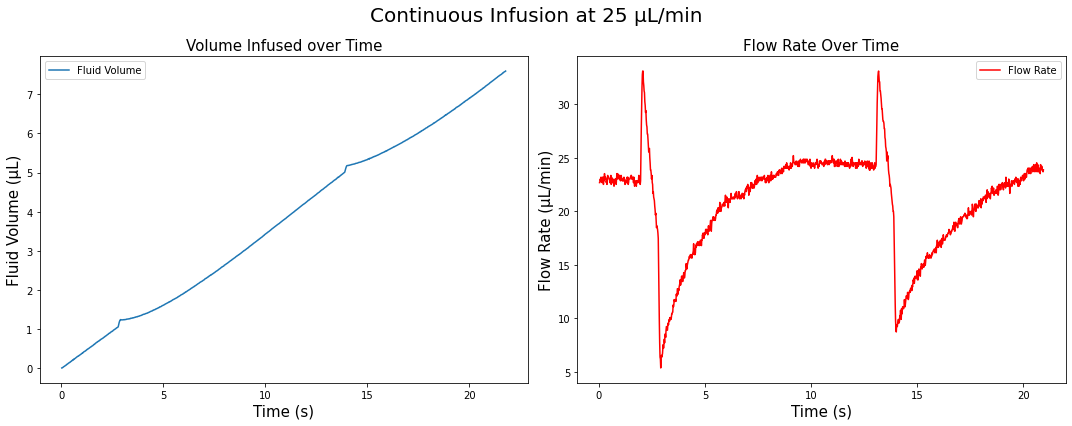

In [4]:
def main(path, title = 'Plot Title', threshold = 6, radius_mm=0.127, framerate = 60):
    #video_path = '/Users/Kara/Desktop/DSCPM_10ulpermin.mov'
    video_path = path
    #video_path = '/Users/Kara/Desktop/DSCPM_25ulpm_jun30.mov'
    frame_rate = framerate  # You need to know the frame rate of the video
    
    # Convert video to 3D array
    video_array = video_to_3d_array(video_path)
    
    # Detect edges and find fluid positions with adjustable threshold
    edge_threshold = threshold  # You can adjust this value to improve edge detection
    fluid_positions, width_ = detect_edges_and_find_fluid_position(video_array, edge_threshold)
    
    # Interpolate missing positions
    fluid_positions = interpolate_missing_positions(fluid_positions)
    
    # Calculate fluid volumes
    fluid_volumes = calculate_volume(fluid_positions, width = width_, radius_mm=0.127)
    
    # Calculate flow rate
    flow_rate = calculate_flow_rate(fluid_volumes, frame_rate)
    
    # Plot fluid volume and flow rate over time
    time, volumes, flrtime, flowrate = plot_fluid_volume_and_flow_rate(fluid_volumes, flow_rate, frame_rate, title)
    
    return time, volumes, flrtime, flowrate


time25, volumes25, flrtime25, flowrate25 = main('/Users/Kara/Desktop/DSCPM_25ulpm_jun30.mov', title = "Continuous Infusion at 25 µL/min", threshold = 3)

In [5]:
import imageio

def get_video_dimensions(video_path):
    # Read the video file
    reader = imageio.get_reader(video_path, 'ffmpeg')
    
    # Get the first frame
    frame = reader.get_data(0)
    
    # Get the dimensions of the frame
    height, width, _ = frame.shape
    
    return width, height

def main1():
    video_path = '/Users/Kara/Desktop/DSCPM_25ulpm_jun30.mov'  # Replace with the path to your video
    width, height = get_video_dimensions(video_path)
    print(f"Video dimensions: {width} x {height} pixels")


main1()


Video dimensions: 3258 x 60 pixels


Processing frames for edge detection: 100%|██████████| 2812/2812 [01:21<00:00, 34.36it/s]


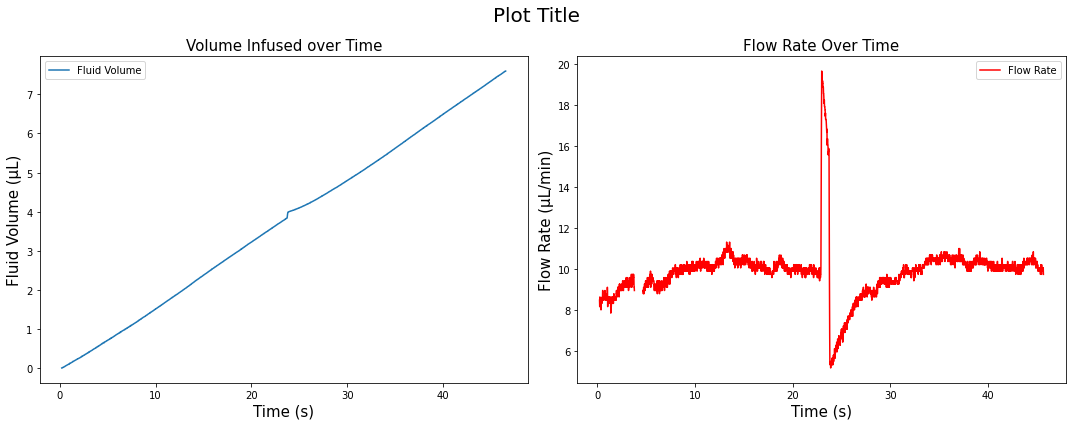

In [17]:
time10, volumes10, flrtime10, flowrate10 = main('/Users/Kara/Desktop/DSCPM_10ulpm_jun30.mov')

Processing frames for edge detection: 100%|██████████| 18261/18261 [10:03<00:00, 30.28it/s]


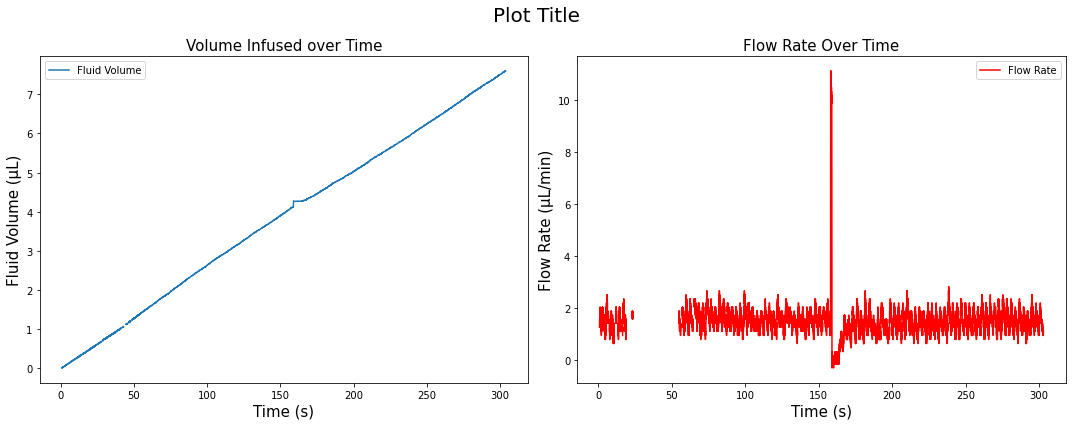

In [15]:
time1_5, volumes1_5, flrtime1_5, flowrate1_5 = main('/Users/Kara/Desktop/DSCPM_1_5_ulpm_jun30.mov', threshold = 7)

In [77]:
time_rate_1_5 = np.stack((flrtime1_5, flowrate1_5), axis=1)
time_rate_1_5.shape



(18211, 2)

Vol is 0.04565585123447133
[[-145.                   nan]
 [-144.98333333           nan]
 [-144.96666667           nan]
 ...
 [ 158.46666667           nan]
 [ 158.48333333           nan]
 [ 158.5                  nan]]


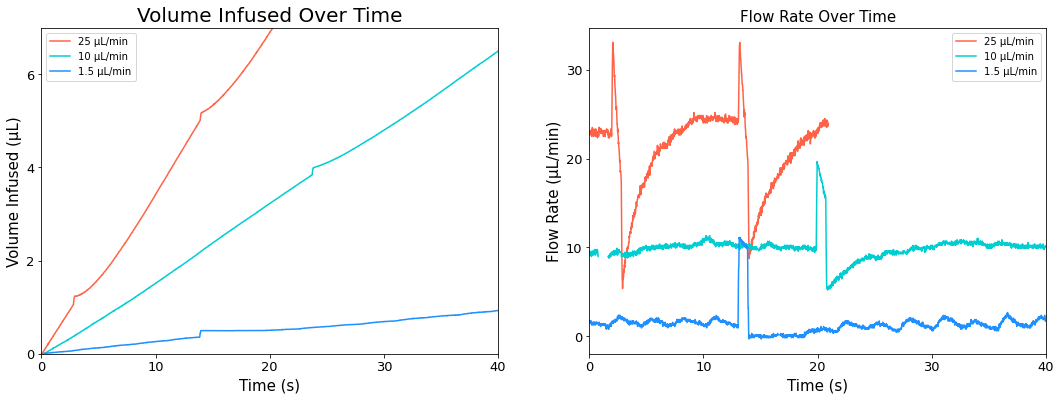

In [130]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(time25, volumes25, label='25 µL/min', color='tomato')

time10_ = time10 - 3
ind = np.where(time10 == 3)
volumes10_ = volumes10 - volumes10[ind]

ax1.plot(time10, volumes10, label='10 µL/min', color='darkturquoise')

time1_5_ = time1_5 - 145
ind = np.where(time1_5 == 145)
volumes1_5_ = volumes1_5 - volumes1_5[ind]

print("Vol is", volumes1_5[145])

ax1.plot(time1_5_, volumes1_5_, label='1.5 µL/min', color='dodgerblue')
ax1.set_title('Volume Infused Over Time', fontsize = 20)
ax1.set_xlabel('Time (s)', fontsize = 15)
ax1.set_ylabel('Volume Infused (µL)', fontsize = 15)
ax1.legend()

ax1.set_xlim(0, 40)
ax1.set_ylim(0, 7)
ax1.set_xticks([0, 10, 20, 30, 40])
ax1.set_yticks([0, 2, 4, 6])
ax1.tick_params(axis='both', which='major', labelsize=13)

ax2.plot(flrtime25, flowrate25, label='25 µL/min', color='tomato')

flrtime10_ = flrtime10 - 3
ind = np.where(flrtime10 == 3)
#flowrate10_ = flowrate10 - flowrate10[ind]

ax2.plot(flrtime10_, flowrate10, label='10 µL/min', color='darkturquoise')

flrtime1_5_ = flrtime1_5 - 145
ind2 = np.where(flrtime1_5 == 145)
#flowrate1_5_ = flowrate1_5 - flowrate1_5[ind2]

ax2.plot(flrtime1_5_, flowrate1_5, label='1.5 µL/min', color='dodgerblue')
ax2.set_title('Flow Rate Over Time', fontsize = 15)
ax2.set_xlabel('Time (s)', fontsize = 15)
ax2.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax2.legend()

time_rate_1_5 = np.stack((flrtime1_5_, flowrate1_5_), axis=1)
print(time_rate_1_5)

ax2.set_xlim(0, 40)
ax2.set_xticks([0, 10, 20, 30, 40])
ax2.set_yticks([0, 10, 20, 30])
ax2.tick_params(axis='both', which='major', labelsize=13)

#plt.suptitle("Fluid Position and Flow Rate with the DSCPM", fontsize = 20)
#plt.tight_layout()

plt.savefig('fig4_contflow.svg', format='svg', dpi=300)
plt.show()

In [124]:
import numpy as np

# Example numpy array with NaN values (substitute with your actual array)


# Find the max, min, and average values, ignoring NaN values
max_value = np.nanmax(flowrate25)
min_value = np.nanmin(flowrate25)
average_value = np.nanmean(flowrate25)

# Print the results
print(f"Max value: {max_value}")
print(f"Min value: {min_value}")
print(f"Average value: {average_value}")


Max value: 33.089958027250965
Min value: 5.375018562802184
Average value: 20.86323511914107


In [125]:
import numpy as np

# Example numpy array with NaN values (substitute with your actual array)


# Find the max, min, and average values, ignoring NaN values
max_value = np.nanmax(flowrate10)
min_value = np.nanmin(flowrate10)
average_value = np.nanmean(flowrate10)

# Print the results
print(f"Max value: {max_value}")
print(f"Min value: {min_value}")
print(f"Average value: {average_value}")


Max value: 19.679375626628953
Min value: 5.195355165430023
Average value: 9.865240861382517


In [126]:
import numpy as np

# Example numpy array with NaN values (substitute with your actual array)


# Find the max, min, and average values, ignoring NaN values
max_value = np.nanmax(flowrate1_5)
min_value = np.nanmin(flowrate1_5)
average_value = np.nanmean(flowrate1_5)

# Print the results
print(f"Max value: {max_value}")
print(f"Min value: {min_value}")
print(f"Average value: {average_value}")


Max value: 11.113938643362793
Min value: -0.3130686941792291
Average value: 1.4885987711648672


(76, 2)
(901, 2)


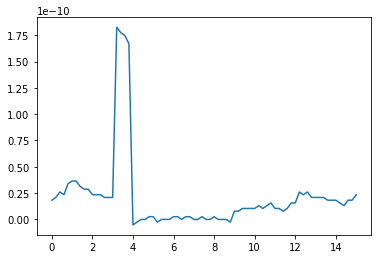

In [118]:
time_rate_1_5 = np.stack((flrtime1_5_, flowrate1_5), axis=1)

# Assuming time_rate_1_5 is already defined
# and the first column represents the time

# Create a boolean mask for the condition (10 <= time <= 20)
mask = (time_rate_1_5[:, 0] >= 10) & (time_rate_1_5[:, 0] <= 25)

# Apply the mask to truncate the array
truncated_time_rate_1_5 = time_rate_1_5[mask]



#plt.plot(truncated_time_rate_1_5[:,0],truncated_time_rate_1_5[:,1])

(a,b) = np.shape(truncated_time_rate_1_5)

conversion_factor = 1e-9 / 60

truncated_time_rate_1_5_short = truncated_time_rate_1_5[::12, :]

truncated_time_rate_1_5_short[:, 1] *= conversion_factor
truncated_time_rate_1_5_short[:, 0] -= truncated_time_rate_1_5_short[0, 0]


plt.plot(truncated_time_rate_1_5_short[:,0],truncated_time_rate_1_5_short[:,1])
np.savetxt("truncated_time_rate_1_5_short.csv", truncated_time_rate_1_5_short, delimiter=",")


print(truncated_time_rate_1_5_short.shape)
print(truncated_time_rate_1_5.shape)

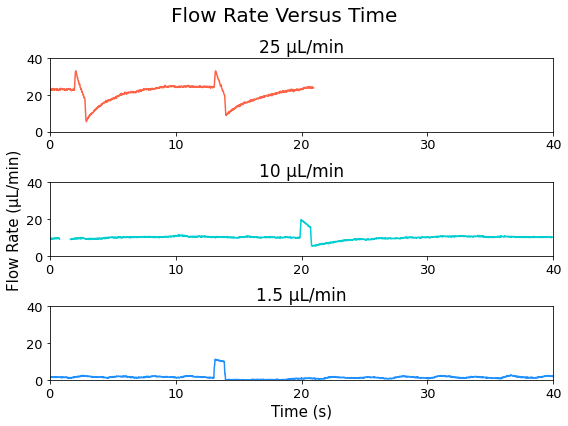

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,6))

ax1.plot(flrtime25, flowrate25, label='25 µL/min', color='tomato')
ax1.set_xlim(0, 40)
ax1.set_title('25 µL/min', fontsize = 17)
ax1.set_ylim(0, 40)
#ax1.set_xlabel('Time (s)', fontsize = 15)
#ax1.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_xticks([0, 10, 20, 30, 40])

ax2.plot(flrtime10_, flowrate10, label='10 µL/min', color='darkturquoise')
ax2.set_xlim(0, 40)
ax2.set_ylim(0, 40)
ax2.set_title('10 µL/min', fontsize = 17)
#ax2.set_xlabel('Time (s)', fontsize = 15)
ax2.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_xticks([0, 10, 20, 30, 40])

ax3.plot(flrtime1_5_, flowrate1_5, label='1.5 µL/min', color='dodgerblue')
ax3.set_xlim(0, 40)
ax3.set_ylim(0, 40)
ax3.set_title('1.5 µL/min', fontsize = 17)
ax3.set_xlabel('Time (s)', fontsize = 15)
#ax3.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=13)
ax3.set_xticks([0, 10, 20, 30, 40])

plt.suptitle('Flow Rate Versus Time', fontsize = 20)
plt.tight_layout()

plt.savefig('fig4_contflowRATES.svg', format='svg', dpi=300)

Processing frames for edge detection: 100%|██████████| 5334/5334 [00:46<00:00, 115.30it/s]


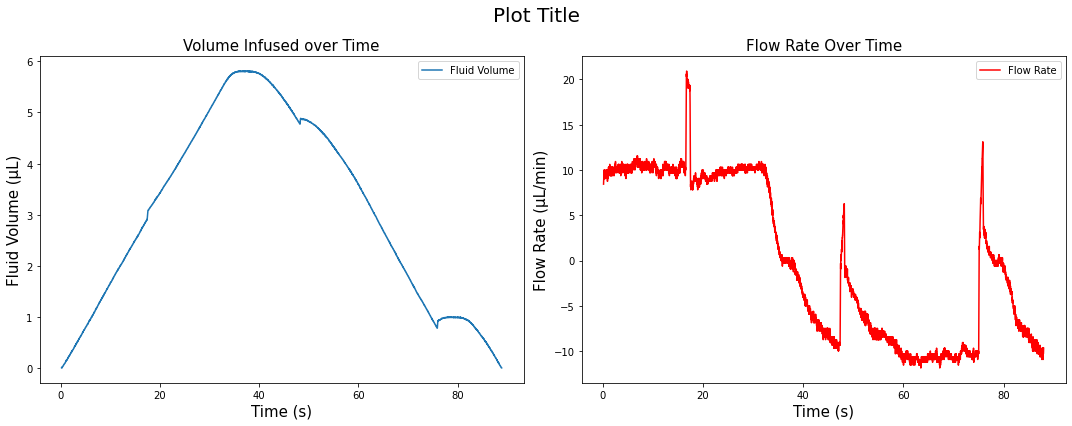

In [131]:
time10r, volumes10r, flrtime10r, flowrate10r = main('/Users/Kara/Desktop/DSCPM_reverse_jun30.mov')

Processing frames for edge detection: 100%|██████████| 2633/2633 [00:23<00:00, 112.79it/s]


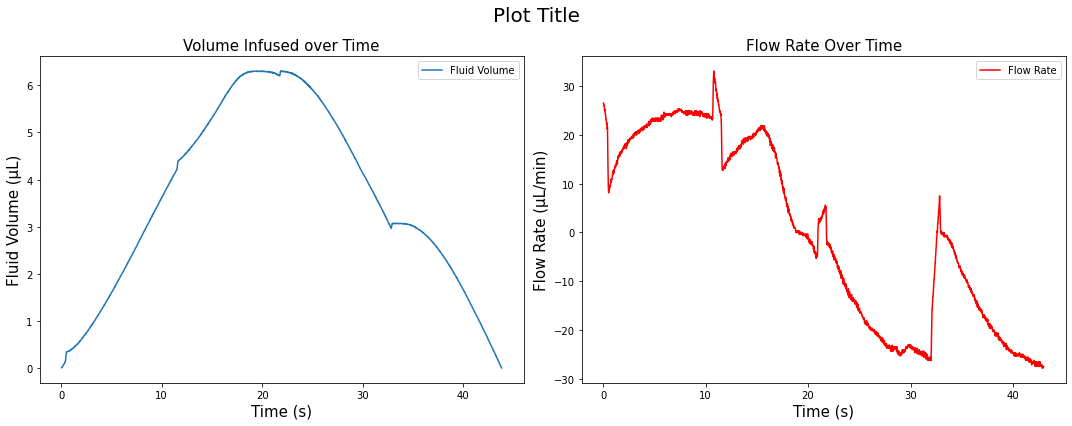

In [132]:
time25r, volumes25r, flrtime25r, flowrate25r = main('/Users/Kara/Desktop/DSCPM_reverse25_jun30.mov')

[[-145.                   nan]
 [-144.98333333           nan]
 [-144.96666667           nan]
 ...
 [ 158.46666667           nan]
 [ 158.48333333           nan]
 [ 158.5                  nan]]


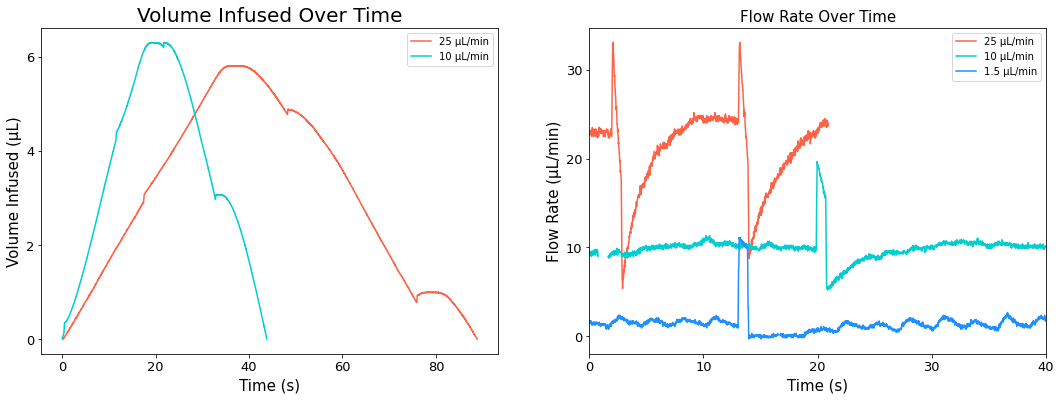

In [134]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(time10r, volumes10r, label='25 µL/min', color='tomato')
ax1.plot(time25r, volumes25r, label='10 µL/min', color='darkturquoise')

ax1.set_title('Volume Infused Over Time', fontsize = 20)
ax1.set_xlabel('Time (s)', fontsize = 15)
ax1.set_ylabel('Volume Infused (µL)', fontsize = 15)
ax1.legend()

#ax1.set_xlim(0, 40)
#ax1.set_ylim(0, 7)
#ax1.set_xticks([0, 10, 20, 30, 40])
ax1.set_yticks([0, 2, 4, 6])
ax1.tick_params(axis='both', which='major', labelsize=13)

ax2.plot(flrtime25, flowrate25, label='25 µL/min', color='tomato')

flrtime10_ = flrtime10 - 3
ind = np.where(flrtime10 == 3)
#flowrate10_ = flowrate10 - flowrate10[ind]

ax2.plot(flrtime10_, flowrate10, label='10 µL/min', color='darkturquoise')

flrtime1_5_ = flrtime1_5 - 145
ind2 = np.where(flrtime1_5 == 145)
#flowrate1_5_ = flowrate1_5 - flowrate1_5[ind2]

ax2.plot(flrtime1_5_, flowrate1_5, label='1.5 µL/min', color='dodgerblue')
ax2.set_title('Flow Rate Over Time', fontsize = 15)
ax2.set_xlabel('Time (s)', fontsize = 15)
ax2.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax2.legend()

time_rate_1_5 = np.stack((flrtime1_5_, flowrate1_5_), axis=1)
print(time_rate_1_5)

ax2.set_xlim(0, 40)
ax2.set_xticks([0, 10, 20, 30, 40])
ax2.set_yticks([0, 10, 20, 30])
ax2.tick_params(axis='both', which='major', labelsize=13)

#plt.suptitle("Fluid Position and Flow Rate with the DSCPM", fontsize = 20)
#plt.tight_layout()

plt.savefig('fig4_ramp.svg', format='svg', dpi=300)
plt.show()

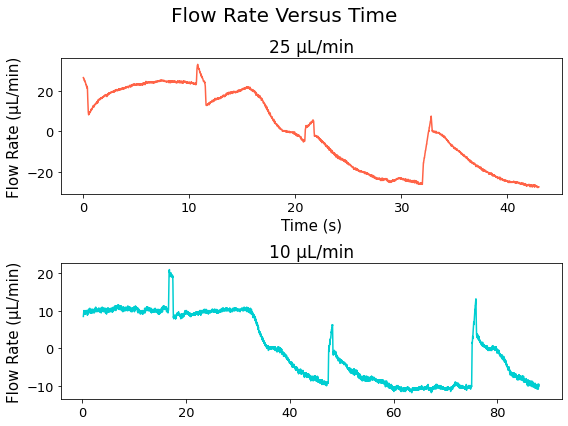

In [138]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

ax1.plot(flrtime25r, flowrate25r, label='25 µL/min', color='tomato')
ax1.set_title('25 µL/min', fontsize = 17)
#ax1.set_ylim(0, 40)
ax1.set_xlabel('Time (s)', fontsize = 15)
ax1.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_xticks([0, 10, 20, 30, 40])

ax2.plot(flrtime10r, flowrate10r, label='10 µL/min', color='darkturquoise')
#ax2.set_xlim(0, 40)
#ax2.set_ylim(0, 40)
ax2.set_title('10 µL/min', fontsize = 17)
#ax2.set_xlabel('Time (s)', fontsize = 15)
ax2.set_ylabel('Flow Rate (µL/min)', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_xticks([0, 20, 40, 60, 80])

plt.suptitle('Flow Rate Versus Time', fontsize = 20)
plt.tight_layout()

plt.savefig('fig4_REVERSEflowRATES.svg', format='svg', dpi=300)